##Importação de Biblioteca

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

##Configuração e Preparação de Dados

In [2]:
try:
    df = pd.read_csv('Steel_industry_data.csv')
    print("Arquivo carregado com sucesso!")
except FileNotFoundError:
    print("ERRO: Faça upload do arquivo 'Steel_industry_data.csv'!")

# Tratamento de dados
df.rename(columns={'Lagging_Current_Reactive.Power_kVarh': 'Reactive_kVarh',
                   'CO2(tCO2)': 'CO2',
                   'date': 'Date_Str'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date_Str'], format='%d/%m/%Y %H:%M')
df['Hour'] = df['Date'].dt.hour
df['Day_Name'] = df['Date'].dt.day_name()

# Ordenar dias da semana para visualização correta
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['Day_Name'] = pd.Categorical(df['Day_Name'], categories=days_order, ordered=True)

Arquivo carregado com sucesso!


##OPÇÃO A: DIAGNÓSTICO AVANÇADO (HEATMAP & TARIFAS)


 [OPÇÃO A] DIAGNÓSTICO DE PADRÕES E CUSTOS 


/tmp/ipython-input-2429416852.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = df.pivot_table(index='Hour', columns='Day_Name', values='Usage_kWh', aggfunc='mean')


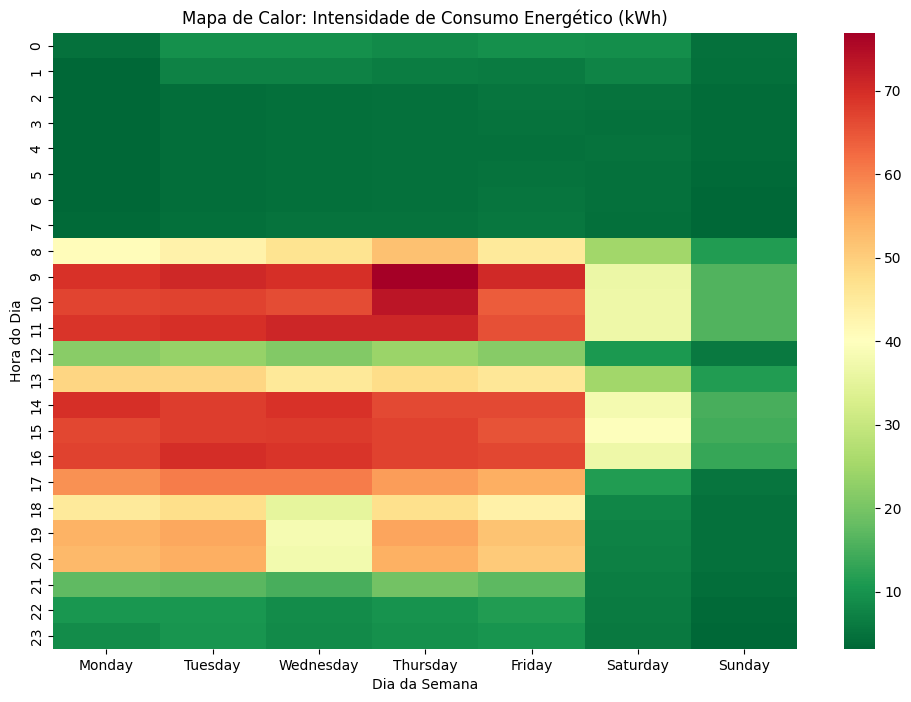

INSIGHT: O mapa mostra claramente que o consumo é crítico nos dias úteis durante o horário comercial.
As áreas vermelhas são os alvos prioritários para nossa solução.


In [3]:
print("\n [OPÇÃO A] DIAGNÓSTICO DE PADRÕES E CUSTOS ")

# Mapa de Calor (Heatmap) - Visualização de Impacto
# Mostra onde o consumo é crítico cruzando Hora x Dia
heatmap_data = df.pivot_table(index='Hour', columns='Day_Name', values='Usage_kWh', aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='RdYlGn_r', annot=False, fmt=".1f")
plt.title('Mapa de Calor: Intensidade de Consumo Energético (kWh)')
plt.xlabel('Dia da Semana')
plt.ylabel('Hora do Dia')
plt.show()

print("INSIGHT: O mapa mostra claramente que o consumo é crítico nos dias úteis durante o horário comercial.")
print("As áreas vermelhas são os alvos prioritários para nossa solução.")

# Simulação de Tarifas (Adicionando valor econômico à análise)
# Hipótese: Tarifa Ponta (18h-21h) custa 3x mais que a normal.
# Custo Base: R$ 0.50/kWh | Custo Ponta: R$ 1.50/kWh | Fim de Semana: R$ 0.40/kWh
def calculate_tariff(row):
    if row['WeekStatus'] == 'Weekend':
        return 0.40
    elif 18 <= row['Hour'] <= 20: # Horário de Ponta
        return 1.50
    else:
        return 0.50

df['Tariff_Price'] = df.apply(calculate_tariff, axis=1)
df['Cost_Original_R$'] = df['Usage_kWh'] * df['Tariff_Price']

##OPÇÃO C: SIMULAÇÃO DE SOLUÇÃO COMPLETA (SOLAR + ECONOMIA)

----------------------------------------
RELATÓRIO DE IMPACTO ANUAL (ESTIMADO)
----------------------------------------
1. Custo Energético Original:   R$ 619,193.65
2. Custo com Solução Solar:     R$ 474,465.52
3. ECONOMIA FINANCEIRA ANUAL:   R$ 144,728.13 (23.4%)
4. IMPACTO AMBIENTAL:           126.4 toneladas de CO2 evitadas
----------------------------------------


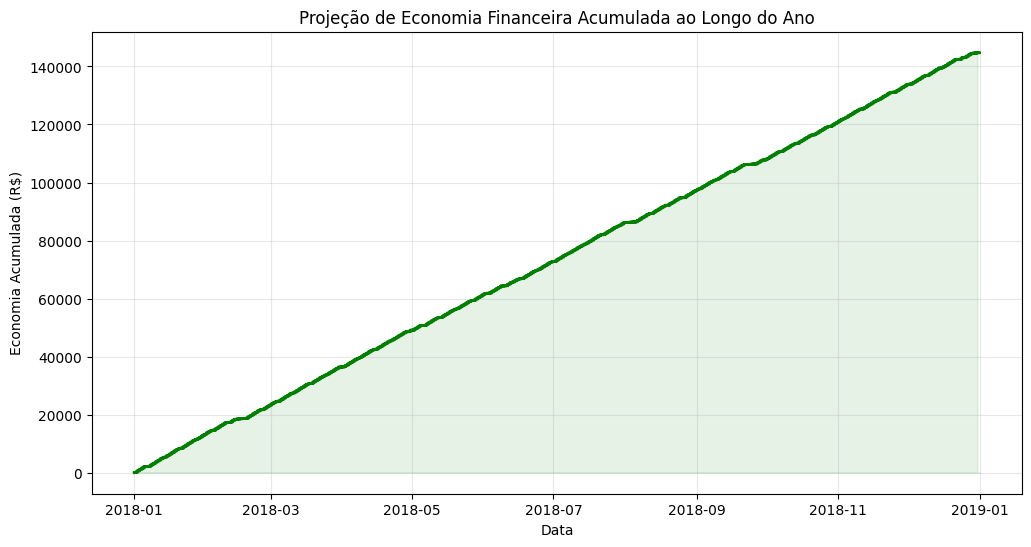

In [9]:
# Parâmetros da Usina Solar Simulada
SOLAR_CAPACITY_KW = 150  # Aumentamos para 150kWp para cobrir melhor a demanda

# Função de Geração Solar (Curva Senoidal)
def simulate_solar(hour):
    if 6 <= hour <= 18:
        return max(0, np.sin(np.pi * (hour - 6) / 12))
    return 0

# Cálculos de Geração e Economia
df['Solar_Gen_kWh'] = df['Hour'].apply(simulate_solar) * SOLAR_CAPACITY_KW * 0.25
# Net Usage: O que sobra para a rede fornecer
df['Net_Usage_kWh'] = (df['Usage_kWh'] - df['Solar_Gen_kWh']).clip(lower=0)
# Custo Otimizado: Pagamos apenas pelo Net Usage
df['Cost_Optimized_R$'] = df['Net_Usage_kWh'] * df['Tariff_Price']

# Consolidação dos Resultados Anuais
total_cost_old = df['Cost_Original_R$'].sum()
total_cost_new = df['Cost_Optimized_R$'].sum()
savings_money = total_cost_old - total_cost_new
savings_pct = (savings_money / total_cost_old) * 100

co2_avoided = (df['Usage_kWh'].sum() - df['Net_Usage_kWh'].sum()) * (df['CO2'].sum() / df['Usage_kWh'].sum())

# Relatório Final
print(f"-"*40)
print(f"RELATÓRIO DE IMPACTO ANUAL (ESTIMADO)")
print(f"-"*40)
print(f"1. Custo Energético Original:   R$ {total_cost_old:,.2f}")
print(f"2. Custo com Solução Solar:     R$ {total_cost_new:,.2f}")
print(f"3. ECONOMIA FINANCEIRA ANUAL:   R$ {savings_money:,.2f} ({savings_pct:.1f}%)")
print(f"4. IMPACTO AMBIENTAL:           {co2_avoided:.1f} toneladas de CO2 evitadas")
print(f"-"*40)

# Gráfico de Economia Acumulada
df['Cumulative_Savings'] = (df['Cost_Original_R$'] - df['Cost_Optimized_R$']).cumsum()

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Cumulative_Savings'], color='green', linewidth=2)
plt.title('Projeção de Economia Financeira Acumulada ao Longo do Ano')
plt.ylabel('Economia Acumulada (R$)')
plt.xlabel('Data')
plt.grid(True, alpha=0.3)
plt.fill_between(df['Date'], df['Cumulative_Savings'], color='green', alpha=0.1)
plt.show()

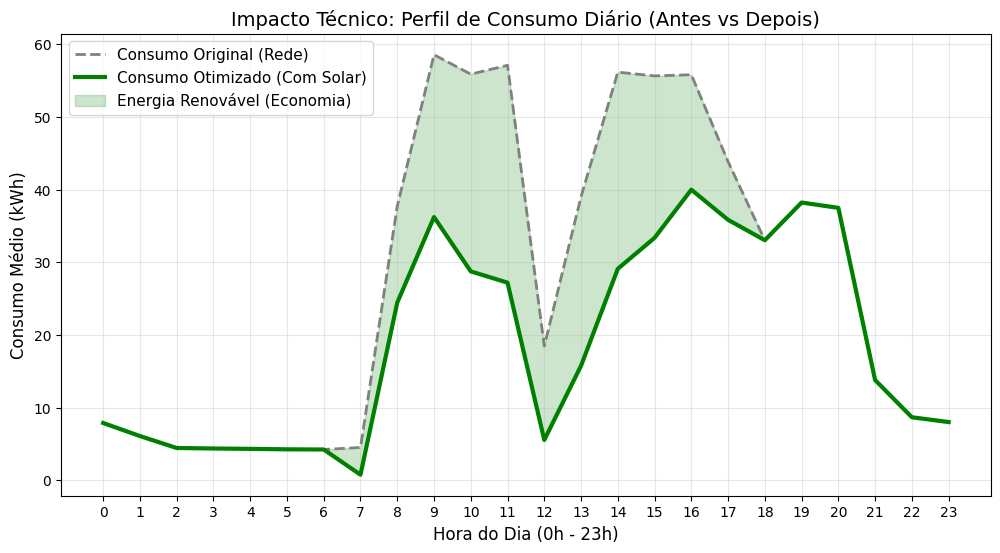

In [10]:
# Gráfico Perfil Técnico (Cinza Vs Verde)
# Agrupar perfil médio por hora (necessário para este gráfico)
daily_profile = df.groupby('Hour')[['Usage_kWh', 'Net_Usage_kWh', 'Solar_Gen_kWh']].mean()

plt.figure(figsize=(12, 6))

# Linha Cinza (Antes da Solução)
plt.plot(daily_profile.index, daily_profile['Usage_kWh'],
         label='Consumo Original (Rede)', color='gray', linestyle='--', linewidth=2)

# Linha Verde (Depois da Solução)
plt.plot(daily_profile.index, daily_profile['Net_Usage_kWh'],
         label='Consumo Otimizado (Com Solar)', color='green', linewidth=3)

# Área Verde (A Economia Gerada)
plt.fill_between(daily_profile.index, daily_profile['Net_Usage_kWh'], daily_profile['Usage_kWh'],
                 color='green', alpha=0.2, label='Energia Renovável (Economia)')

# Detalhes do Gráfico
plt.title('Impacto Técnico: Perfil de Consumo Diário (Antes vs Depois)', fontsize=14)
plt.xlabel('Hora do Dia (0h - 23h)', fontsize=12)
plt.ylabel('Consumo Médio (kWh)', fontsize=12)
plt.xticks(range(0, 24)) # Mostra todas as horas no eixo X
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)

plt.show()